Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\USER\miniconda3\envs\obspy_env\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_26640\615295283.py", line 390, in load_file
    self.compute()
    ~~~~~~~~~~~~^^
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_26640\615295283.py", line 405, in compute
    ok = self.detector.compute_sta_lta(sta, lta, thr_on, thr_off, start_analysis, end_analysis)
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_26640\615295283.py", line 81, in compute_sta_lta
    sta[:] = (cumsum[nsta:] - cumsum[:-nsta]) / float(nsta)
    ~~~^^^
ValueError: could not broadcast input array from shape (360179,) into shape (360278,)


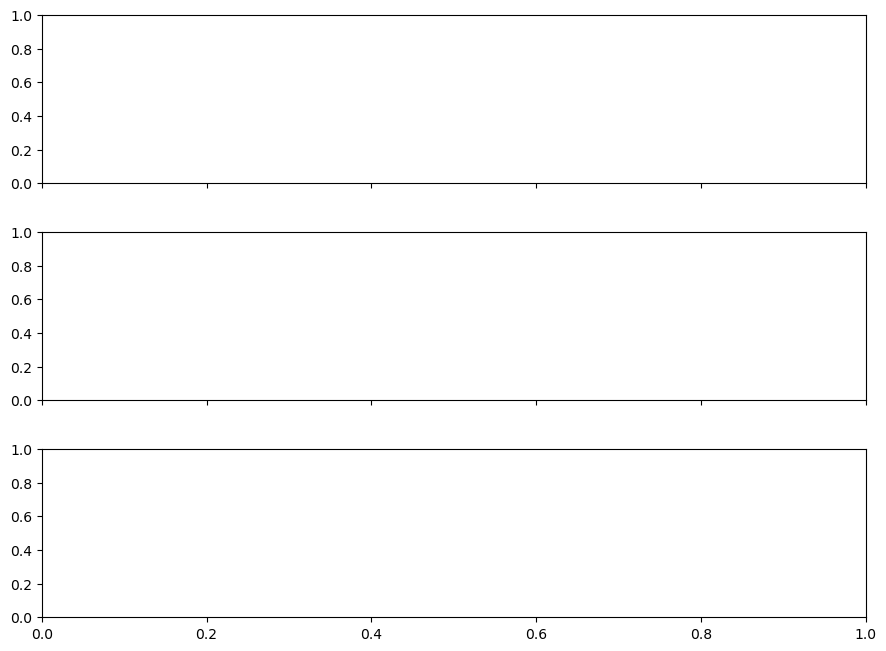

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from obspy import read
import os

#  KELAS DETEKTOR STA/LTA
class STALTADetector:
    """
    Kelas ini berfungsi untuk melakukan proses inti STA/LTA:
    - Memuat file MiniSEED
    - Menghitung STA, LTA, dan rasio STA/LTA
    - Menentukan waktu datang (arrival) gelombang
    - Menyimpan hasil deteksi
    """
    def __init__(self):
        self.trace = None
        self.times = None
        self.sta = None
        self.lta = None
        self.ratio = None
        self.triggers = []
        self.picks = []
        self.last_thresh_on = 3.0
        self.last_thresh_off = 1.0

    def load_mseed(self, filepath):
        """Memuat file MiniSEED dan melakukan pra-pemrosesan."""
        try:
            st = read(filepath)
            if len(st) == 0:
                raise ValueError("File MiniSEED kosong")

            self.trace = st[0]
            # Pra-pemrosesan dasar
            try:
                self.trace.detrend("linear")
            except Exception:
                pass
            try:
                self.trace.filter("bandpass", freqmin=1.0, freqmax=10.0)
            except Exception:
                # jika filter gagal, lanjut tanpa filter
                pass

            # waktu relatif dalam detik dari starttime
            npts = self.trace.stats.npts
            fs = self.trace.stats.sampling_rate
            self.times = np.arange(npts) / fs
            return True
        except Exception as e:
            messagebox.showerror("Error", f"Gagal load file: {str(e)}")
            return False

    def compute_sta_lta(self, sta_sec=1.0, lta_sec=30.0, thresh_on=3.0, thresh_off=1.0, start_sec=0.0, end_sec=None):
        """Menghitung nilai STA, LTA, dan rasio STA/LTA untuk mendeteksi gelombang."""
        if self.trace is None:
            return False

        data = np.abs(self.trace.data.astype(float))
        fs = self.trace.stats.sampling_rate
        nsta = max(1, int(round(sta_sec * fs)))
        nlta = max(1, int(round(lta_sec * fs)))

        if nsta >= len(data) or nlta >= len(data):
            messagebox.showwarning("Parameter", "Window STA/LTA terlalu besar untuk data")
            return False

        # Hitung cumulative sum agar perhitungan moving average cepat
        cumsum = np.empty(len(data) + 1, dtype=float)
        cumsum[0] = 0.0
        cumsum[1:] = np.cumsum(data)

        # moving sums: sum over window = cumsum[i] - cumsum[i - window]
        sta = np.zeros(len(data), dtype=float)
        lta = np.zeros(len(data), dtype=float)

        # STA: menggunakan rata-rata window nsta
        sta[:] = (cumsum[nsta:] - cumsum[:-nsta]) / float(nsta)

        # Untuk awal (kurang dari nsta), kita bisa gunakan nilai rata-rata bertambah:
        for i in range(min(nsta, len(data))):
            sta[i] = cumsum[i+1] / float(i+1)

        # LTA: menggunakan window nlta
        lta[:] = (cumsum[nlta:] - cumsum[:-nlta]) / float(nlta)
        for i in range(min(nlta, len(data))):
            lta[i] = cumsum[i+1] / float(i+1)

        # Hindari nol
        lta[lta == 0] = 1e-10

        self.sta = sta
        self.lta = lta
        self.ratio = self.sta / self.lta

        # Simpan nilai threshold terakhir
        self.last_thresh_on = float(thresh_on)
        self.last_thresh_off = float(thresh_off)

        # Deteksi waktu trigger
        self.triggers = []
        self.picks = []
        in_trigger = False
        on_time = None

        for i in range(len(self.ratio)):
            if not in_trigger and self.ratio[i] > thresh_on:
                on_time = self.times[i]
                self.picks.append(on_time)
                in_trigger = True
            elif in_trigger and self.ratio[i] < thresh_off:
                off_time = self.times[i]
                if on_time is None:
                    on_time = self.times[i]
                self.triggers.append((on_time, off_time))
                in_trigger = False
                on_time = None

        # Jika trigger masih terbuka hingga akhir, tutup dengan waktu akhir
        if in_trigger and on_time is not None:
            self.triggers.append((on_time, self.times[-1]))

        # Filter picks dan triggers berdasarkan rentang analisis
        if end_sec is None:
            end_sec = self.times[-1]
        try:
            start_sec = float(start_sec)
            end_sec = float(end_sec)
        except Exception:
            start_sec = 0.0
            end_sec = self.times[-1]

        self.picks = [p for p in self.picks if start_sec <= p <= end_sec]
        self.triggers = [(on, off) for on, off in self.triggers if start_sec <= on <= end_sec]

        return True

    def plot(self, ax_trace, ax_stalta, ax_ratio, xlim=None):
        """Menampilkan tiga grafik: sinyal asli, STA-LTA, dan rasio STA/LTA."""
        ax_trace.clear()
        ax_stalta.clear()
        ax_ratio.clear()

        if self.trace is None:
            ax_trace.set_title("Belum ada data")
            return

        # Plot sinyal asli
        ax_trace.plot(self.times, self.trace.data, linewidth=0.8)
        ax_trace.set_ylabel("Amplitudo")
        ax_trace.set_title("Sinyal Asli")
        ax_trace.grid(True)

        # Plot STA dan LTA (jika sudah dihitung)
        if self.sta is not None and self.lta is not None:
            ax_stalta.plot(self.times, self.sta, label='STA', linewidth=0.8)
            ax_stalta.plot(self.times, self.lta, label='LTA', linewidth=0.8)
            ax_stalta.set_ylabel("Nilai")
            ax_stalta.set_title("STA (biru) & LTA (merah)")
            ax_stalta.legend()
            ax_stalta.grid(True)
        else:
            ax_stalta.set_title("STA/LTA belum dihitung")

        # Plot rasio STA/LTA
        if self.ratio is not None:
            ax_ratio.plot(self.times, self.ratio, label='STA/LTA', linewidth=0.8)

            # Garis ambang threshold ON dan OFF 
            ax_ratio.axhline(self.last_thresh_on, linestyle='--', linewidth=1.0,
                             label=f'Th ON ({self.last_thresh_on})')
            ax_ratio.axhline(self.last_thresh_off, linestyle='--', linewidth=1.0,
                             label=f'Th OFF ({self.last_thresh_off})')

            # Area waktu trigger
            for on_time, off_time in self.triggers:
                ax_ratio.axvspan(on_time, off_time, alpha=0.25)
            for pick in self.picks:
                ax_ratio.axvline(pick, linestyle='--', linewidth=1.0)
                ax_trace.axvline(pick, linestyle='--', linewidth=1.0)
                ax_stalta.axvline(pick, linestyle='--', linewidth=1.0)

            ax_ratio.set_ylabel("Ratio")
            ax_ratio.set_xlabel("Waktu (detik)")
            ax_ratio.set_title(f"STA/LTA Ratio | Picks: {len(self.picks)}")
            ax_ratio.legend()
            ax_ratio.grid(True)
        else:
            ax_ratio.set_title("Ratio belum dihitung")

        if xlim:
            try:
                ax_trace.set_xlim(xlim)
                ax_stalta.set_xlim(xlim)
                ax_ratio.set_xlim(xlim)
            except Exception:
                pass


#  KELAS GUI APLIKASI
class STALTAApp(tk.Tk):
    """Aplikasi GUI STA/LTA untuk deteksi waktu datang gelombang."""
    def __init__(self):
        super().__init__()
        self.title("STA/LTA Detector - Deteksi Waktu Datang Gelombang")
        self.geometry("1400x900")
        self.detector = STALTADetector()
        self.create_widgets()

    def create_widgets(self):
        """Membuat seluruh elemen GUI."""
        # Container untuk control frame dengan scrollbar
        control_container = ttk.Frame(self)
        control_container.pack(side=tk.LEFT, fill=tk.Y)

        # Canvas untuk scrolling
        self.canvas = tk.Canvas(control_container, width=320, height=900)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Scrollbar vertikal
        scrollbar = ttk.Scrollbar(control_container, orient="vertical", command=self.canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas.configure(yscrollcommand=scrollbar.set)

        # Frame di dalam canvas
        control_frame = ttk.Frame(self.canvas, padding=10)
        self.canvas.create_window((0, 0), window=control_frame, anchor="nw")

        # Bind untuk update scroll region
        control_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))

        ttk.Button(control_frame, text="Load File MiniSEED", command=self.load_file).pack(fill=tk.X, pady=5)

        ttk.Label(control_frame, text="STA: Short-Term Average (rata-rata jangka pendek)\nLTA: Long-Term Average (rata-rata jangka panjang)\nSTA/LTA digunakan untuk deteksi onset gelombang.", wraplength=280).pack(pady=5)

        # STA Slider
        ttk.Label(control_frame, text="STA (detik):").pack(pady=2)
        self.var_sta = tk.DoubleVar(value=1.0)
        self.scale_sta = ttk.Scale(control_frame, from_=0.1, to=10.0, orient=tk.HORIZONTAL, variable=self.var_sta, command=self.update_labels)
        self.scale_sta.pack(fill=tk.X)
        self.scale_sta.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_sta_val = ttk.Label(control_frame, text="1.0")
        self.label_sta_val.pack()

        # LTA Slider
        ttk.Label(control_frame, text="LTA (detik):").pack(pady=2)
        self.var_lta = tk.DoubleVar(value=30.0)
        self.scale_lta = ttk.Scale(control_frame, from_=1.0, to=100.0, orient=tk.HORIZONTAL, variable=self.var_lta, command=self.update_labels)
        self.scale_lta.pack(fill=tk.X)
        self.scale_lta.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_lta_val = ttk.Label(control_frame, text="30.0")
        self.label_lta_val.pack()

        # Threshold ON Slider
        ttk.Label(control_frame, text="Threshold ON:").pack(pady=2)
        self.var_on = tk.DoubleVar(value=3.0)
        self.scale_on = ttk.Scale(control_frame, from_=1.0, to=10.0, orient=tk.HORIZONTAL, variable=self.var_on, command=self.update_labels)
        self.scale_on.pack(fill=tk.X)
        self.scale_on.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_on_val = ttk.Label(control_frame, text="3.0")
        self.label_on_val.pack()

        # Threshold OFF Slider
        ttk.Label(control_frame, text="Threshold OFF:").pack(pady=2)
        self.var_off = tk.DoubleVar(value=1.0)
        self.scale_off = ttk.Scale(control_frame, from_=0.1, to=5.0, orient=tk.HORIZONTAL, variable=self.var_off, command=self.update_labels)
        self.scale_off.pack(fill=tk.X)
        self.scale_off.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_off_val = ttk.Label(control_frame, text="1.0")
        self.label_off_val.pack()

        # Analysis Range
        ttk.Label(control_frame, text="Analysis Range (detik) - untuk melewatkan waktu yang tidak ingin dianalisis:").pack(pady=5)
        ttk.Label(control_frame, text="Start Analysis:").pack()
        self.var_analysis_start = tk.DoubleVar(value=0.0)
        self.scale_analysis_start = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_analysis_start, command=self.update_analysis_labels)
        self.scale_analysis_start.pack(fill=tk.X)
        self.scale_analysis_start.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_analysis_start_val = ttk.Label(control_frame, text="0.0")
        self.label_analysis_start_val.pack()

        ttk.Label(control_frame, text="End Analysis:").pack()
        self.var_analysis_end = tk.DoubleVar(value=1000.0)
        self.scale_analysis_end = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_analysis_end, command=self.update_analysis_labels)
        self.scale_analysis_end.pack(fill=tk.X)
        self.scale_analysis_end.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_analysis_end_val = ttk.Label(control_frame, text="1000.0")
        self.label_analysis_end_val.pack()

        # Zoom Durasi
        ttk.Label(control_frame, text="Zoom Durasi (detik):").pack(pady=5)
        ttk.Label(control_frame, text="Start:").pack()
        self.var_start = tk.DoubleVar(value=0.0)
        self.scale_start = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_start, command=self.update_zoom)
        self.scale_start.pack(fill=tk.X)
        self.label_start_val = ttk.Label(control_frame, text="0.0")
        self.label_start_val.pack()

        ttk.Label(control_frame, text="End:").pack()
        self.var_end = tk.DoubleVar(value=1000.0)
        self.scale_end = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_end, command=self.update_zoom)
        self.scale_end.pack(fill=tk.X)
        self.label_end_val = ttk.Label(control_frame, text="1000.0")
        self.label_end_val.pack()

        ttk.Button(control_frame, text="Compute STA/LTA", command=self.compute).pack(fill=tk.X, pady=10)
        ttk.Button(control_frame, text="Save Plot (PNG)", command=self.save_plot).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Save Picks (TXT)", command=self.save_picks).pack(fill=tk.X, pady=5)

        self.label_info = ttk.Label(control_frame, text="Belum ada data", wraplength=280)
        self.label_info.pack(pady=10)

        # Info Picks
        self.label_picks = ttk.Label(control_frame, text="Picks Info:\nBelum ada picks", wraplength=280)
        self.label_picks.pack(pady=10)

        plot_frame = ttk.Frame(self)
        plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        self.fig.tight_layout(pad=3.0)
        self.canvas_plot = FigureCanvasTkAgg(self.fig, plot_frame)
        self.canvas_plot.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Tambahkan Navigation Toolbar untuk zoom, pan, dll.
        try:
            self.toolbar = NavigationToolbar2Tk(self.canvas_plot, plot_frame)
            self.toolbar.update()
            self.toolbar.pack(side=tk.BOTTOM, fill=tk.X)
        except Exception:
            pass

    def update_labels(self, event=None):
        """Update label nilai slider secara real-time."""
        self.label_sta_val.config(text=f"{self.var_sta.get():.1f}")
        self.label_lta_val.config(text=f"{self.var_lta.get():.1f}")
        self.label_on_val.config(text=f"{self.var_on.get():.1f}")
        self.label_off_val.config(text=f"{self.var_off.get():.1f}")

    def update_analysis_labels(self, event=None):
        """Update label nilai slider analysis range secara real-time."""
        self.label_analysis_start_val.config(text=f"{self.var_analysis_start.get():.1f}")
        self.label_analysis_end_val.config(text=f"{self.var_analysis_end.get():.1f}")

    def update_zoom(self, event=None):
        """Update zoom xlim."""
        self.label_start_val.config(text=f"{self.var_start.get():.1f}")
        self.label_end_val.config(text=f"{self.var_end.get():.1f}")
        if self.detector.trace is not None and self.detector.times is not None:
            x0 = float(self.var_start.get())
            x1 = float(self.var_end.get())
            # jaga agar start < end dan di rentang durasi
            if x1 <= x0:
                return
            duration = self.detector.times[-1]
            x0 = max(0.0, min(x0, duration))
            x1 = max(0.0, min(x1, duration))
            xlim = (x0, x1)
            self.detector.plot(self.ax1, self.ax2, self.ax3, xlim=xlim)
            self.canvas_plot.draw()

    def load_file(self):
        """Memuat file MiniSEED dan menampilkan info dasarnya."""
        filepath = filedialog.askopenfilename(
            title="Pilih file MiniSEED",
            filetypes=[("MiniSEED files", "*.mseed *.MSEED"), ("All files", "*.*")]
        )
        if filepath:
            if self.detector.load_mseed(filepath):
                info_text = (f"Loaded: {os.path.basename(filepath)}\n"
                             f"Channel: {self.detector.trace.stats.channel}\n"
                             f"Start: {self.detector.trace.stats.starttime}\n"
                             f"Samp. Rate: {self.detector.trace.stats.sampling_rate} Hz")
                self.label_info.config(text=info_text)
                # Update zoom slider max berdasarkan durasi data
                duration = float(self.detector.times[-1])
                self.scale_start.config(to=duration)
                self.scale_end.config(to=duration)
                self.var_end.set(duration)
                self.label_end_val.config(text=f"{duration:.1f}")
                # Update analysis range slider max
                self.scale_analysis_start.config(to=duration)
                self.scale_analysis_end.config(to=duration)
                self.var_analysis_end.set(duration)
                self.label_analysis_end_val.config(text=f"{duration:.1f}")
                # Plot awal dan compute default
                self.compute()

    def compute(self):
        """Mengambil input dari GUI dan menghitung STA/LTA."""
        if self.detector.trace is None:
            messagebox.showwarning("Data", "Load file dulu!")
            return

        sta = max(0.001, self.var_sta.get())
        lta = max(0.001, self.var_lta.get())
        thr_on = float(self.var_on.get())
        thr_off = float(self.var_off.get())
        start_analysis = float(self.var_analysis_start.get())
        end_analysis = float(self.var_analysis_end.get())

        ok = self.detector.compute_sta_lta(sta, lta, thr_on, thr_off, start_analysis, end_analysis)
        if ok:
            x0 = float(self.var_start.get())
            x1 = float(self.var_end.get())
            if x1 <= x0:
                xlim = None
            else:
                xlim = (x0, x1)
            self.detector.plot(self.ax1, self.ax2, self.ax3, xlim=xlim)
            self.canvas_plot.draw()
            # Update info picks
            info_base = self.label_info.cget('text').split("\nPicks")[0] if "Picks" in self.label_info.cget('text') else self.label_info.cget('text')
            self.label_info.config(text=f"{info_base}\nPicks terdeteksi: {len(self.detector.picks)}")
            if self.detector.picks:
                picks_text = "Picks Info:\n"
                for i, pick in enumerate(self.detector.picks, 1):
                    utc_time = self.detector.trace.stats.starttime + pick
                    picks_text += f"Pick {i}: {pick:.3f} detik ({utc_time})\n"
                self.label_picks.config(text=picks_text)
            else:
                self.label_picks.config(text="Picks Info:\nBelum ada picks")

    def save_plot(self):
        """Simpan plot saat ini ke file PNG."""
        if self.detector.trace is None:
            messagebox.showwarning("Data", "Tidak ada data untuk disimpan.")
            return
        try:
            fpath = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Image", "*.png")], title="Simpan Plot sebagai PNG")
            if not fpath:
                return
            # simpan figure
            self.fig.savefig(fpath, dpi=200, bbox_inches='tight')
            messagebox.showinfo("Sukses", f"Plot berhasil disimpan ke:\n{fpath}")
        except Exception as e:
            messagebox.showerror("Error", f"Gagal menyimpan plot: {e}")

    def save_picks(self):
        """Simpan daftar picks ke file TXT (detik relatif & waktu UTC)."""
        if self.detector.trace is None or not self.detector.picks:
            messagebox.showwarning("Data", "Tidak ada picks untuk disimpan.")
            return
        try:
            fpath = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text file", "*.txt")], title="Simpan Picks sebagai TXT")
            if not fpath:
                return
            with open(fpath, 'w', encoding='utf-8') as fh:
                fh.write("Index\tPick_seconds\tUTC_time\n")
                for i, pick in enumerate(self.detector.picks, 1):
                    utc_time = self.detector.trace.stats.starttime + pick
                    fh.write(f"{i}\t{pick:.6f}\t{utc_time}\n")
            messagebox.showinfo("Sukses", f"Picks berhasil disimpan ke:\n{fpath}")
        except Exception as e:
            messagebox.showerror("Error", f"Gagal menyimpan picks: {e}")


if __name__ == "__main__":
    app = STALTAApp()
    app.mainloop()
